In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import f_oneway, pearsonr

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

# Helpers
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split

pd.options.display.max_columns = None

In [107]:
# add the movie notebook to path

full = pd.read_csv('../data/enriched_data.csv')
full.dropna(inplace=True)

In [108]:
prefix = ''
target = 'gross'
only_significant = True
reg = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

In [109]:
y = full[target]
X = full.drop(columns=[target])

pred = [
    'duration', 'director_facebook_likes',
    'actor_3_facebook_likes', 'actor_1_facebook_likes',
    'cast_total_facebook_likes', 'budget',
    'actor_2_facebook_likes', 'genre_Drama', 'genre_Comedy', 'genre_Romance',
    'genre_Thriller', 'genre_Crime', 'genre_Action', 'genre_Adventure',
    'genre_Horror', 'genre_Family', 'genre_Fantasy', 'genre_Other',
    'pop_est', 'gdp_md', 'actor_1_degree', 'actor_1_closeness',
    'actor_1_betweenness', 'actor_2_degree', 'actor_2_closeness',
    'actor_2_betweenness', 'actor_3_degree', 'actor_3_closeness',
    'actor_3_betweenness']

corr = pd.DataFrame(columns=['corr', 'p-value'])
for p in pred:
    if p in X.columns:
        ctest = pearsonr(full[p], y)
        corr.loc[p] = ctest
corr["significant"] = corr["p-value"] < 0.05

corr["abs_corr"] = corr["corr"].abs()
max_corr = corr.abs_corr.max()

corr.sort_values(by='p-value')


,corr,p-value,significant,abs_corr
budget,0.480309,8.694141e-59,True,0.480309
cast_total_facebook_likes,0.244441,4.668336e-15,True,0.244441
genre_Family,0.226441,4.407737e-13,True,0.226441
actor_3_facebook_likes,0.217387,3.769313e-12,True,0.217387
actor_2_facebook_likes,0.204573,6.711428e-11,True,0.204573
genre_Adventure,0.195870,4.274117e-10,True,0.195870
actor_1_facebook_likes,0.189878,1.456868e-09,True,0.189878
genre_Drama,-0.175028,2.573509e-08,True,0.175028
gdp_md,0.173474,3.428867e-08,True,0.173474
actor_1_degree,0.133006,2.471345e-05,True,0.133006


In [110]:
if only_significant:
    pred = corr[corr["significant"]].index
X = X[pred]

In [111]:
# Check statsmodels

import statsmodels.api as sm

# replace all boolean columns with 0 and 1

for col in pred:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     20.70
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           6.90e-57
Time:                        09:43:24   Log-Likelihood:                -14352.
No. Observations:                 799   AIC:                         2.874e+04
Df Residuals:                     779   BIC:                         2.884e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1.448e+07   4.99e+06     -2.902      0.004   -2.43e+07   -4.69e+06
duration                   1.962e+05   4.51e+04      4.347      0.000    1.08e+05    2.85e+05
actor_3_facebook_likes    -3298.1002   6061.504     -0.544      0.587   -1.52e+04    8600.716
actor_1_facebook_likes    -3810.0818   3416.844     -1.115      0.265   -1.05e+04    2897.231
cast_total_facebook_likes  2383.6563   1296.617      1.838      0.066    -161.621    4928.934
budget                        0.4951      0.042     11.717      0.000       0.412       0.578
actor_2_facebook_likes      207.5843   4559.141      0.046      0.964   -8742.073    9157.241
genre_Drama               -5.478e+06   1.26e+06     -4.352      0.000   -7.95e+06   -3.01e+06
genre_Comedy              -7.568e+05   1.23e+06     -0.616      0.538   -3.17e+06    1.65e+06
genre_Action              -2.519e+05   1.65e+06     -0.153      0.878   -3.49e+06    2.98e+06
genre_Adventure            3.978e+06   1.81e+06      2.193      0.029    4.18e+05    7.54e+06
genre_Family               8.692e+06   1.99e+06      4.365      0.000    4.78e+06    1.26e+07
pop_est                      -0.0108      0.006     -1.666      0.096      -0.024       0.002
gdp_md                        0.4011      0.114      3.510      0.000       0.177       0.625
actor_1_degree             3.052e+05   3.81e+05      0.801      0.423   -4.43e+05    1.05e+06
actor_1_closeness         -8.753e+07   1.69e+08     -0.517      0.605    -4.2e+08    2.45e+08
actor_1_betweenness        1.452e+08   1.59e+08      0.913      0.361   -1.67e+08    4.57e+08
actor_2_degree            -5.454e+05   3.76e+05     -1.449      0.148   -1.28e+06    1.94e+05
actor_2_closeness          2.223e+08   1.78e+08      1.251      0.211   -1.27e+08    5.71e+08
actor_3_closeness         -1.387e+08   1.64e+08     -0.846      0.398    -4.6e+08    1.83e+08
==============================================================================
Omnibus:                      194.212   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              430.043
Skew:                           1.319   Prob(JB):                     4.14e-94
Kurtosis:                       5.442   Cond. No.                     1.24e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

mean_squared_error: 326367826159929.06
r2_score: 0.25091626645570264
explained_variance_score: 0.26227374438468076
mean_absolute_percentage_error: 15.872692298322384


Text(0.5, 1.0, 'Test')

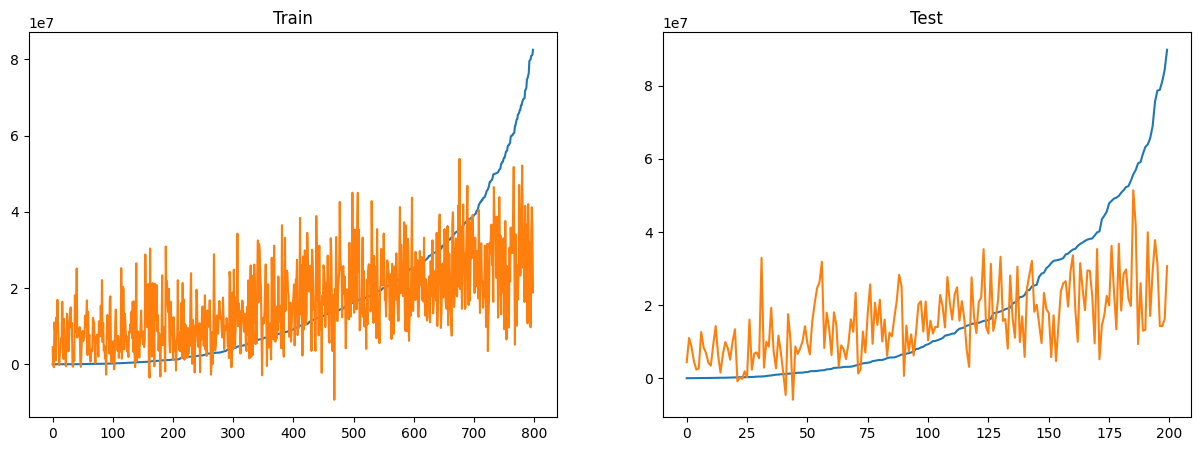

In [112]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error

print(f"mean_squared_error: {mean_squared_error(y_test, y_pred)}")
print(f"r2_score: {r2_score(y_test, y_pred)}")
print(f"explained_variance_score: {explained_variance_score(y_test, y_pred)}")
print(f"mean_absolute_percentage_error: {mean_absolute_percentage_error(y_test, y_pred)}")

y_train = y_train.sort_values()
X_train = X_train.loc[y_train.index]
y_test = y_test.sort_values()
X_test = X_test.loc[y_test.index]

for dataset in [y_train, X_train, y_test, X_test]:
    dataset.reset_index(drop=True, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(y_train)
ax1.plot(model.predict(X_train))
ax1.set_title('Train')
ax2.plot(y_test)
ax2.plot(model.predict(X_test))
ax2.set_title('Test')

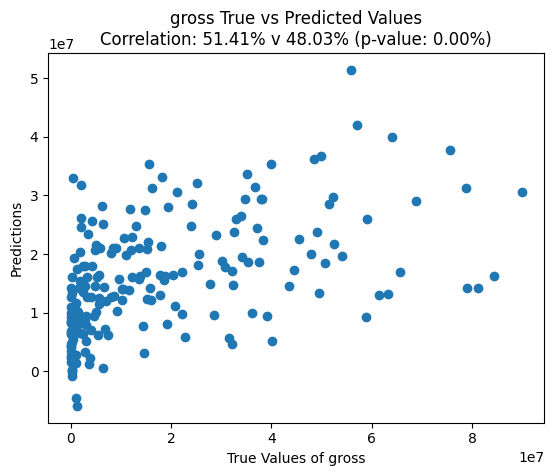

In [113]:
ctest_mod = pearsonr(y_test, model.predict(X_test))

plt.scatter(y_test, model.predict(X_test))
plt.xlabel(f'True Values of {target}')
plt.ylabel('Predictions')
plt.title("".join([
    f'{target} True vs Predicted Values',
    f"\nCorrelation: {ctest_mod[0]:.2%} v {max_corr:.2%} (p-value: {ctest_mod[1]:.2%})"
])),
plt.show()